# MLP 
- author: Tibor Sloboda

In [ ]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from accelerate.data_loader import DataLoader
from datasets import ClassLabel, Dataset, load_dataset
from sklearn.metrics import confusion_matrix
from torch import nn as nn
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer


In [2]:
torch.cuda.device_count()

1

In [ ]:
if (
    torch.cuda.get_device_capability(0)[0] >= 8
):  # A100 is Ampere architecture (compute capability 8.0+)
    # Enable sparse tensor cores
    torch.backends.cuda.matmul.allow_tf32 = (
        True  # This enables TF32 which works with the sparse cores
    )
    # For specific sparse operations
    torch.set_float32_matmul_precision("high")

In [ ]:
class CustomSwiGLU(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()

        assert in_features % 2 == 0, "in_features must be even"

        self.in_features = in_features
        self.linear1 = nn.Linear(in_features // 2, in_features // 2)
        self.linear2 = nn.Linear(in_features // 2, in_features // 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1, x2 = x.chunk(2, dim=-1)
        x1 = self.linear1(x1)
        x2 = self.linear2(x2)
        return F.silu(x1) * x2

In [5]:
class DyT(nn.Module):
    def __init__(self, hidden_size: int, init_alpha: float = 0.5):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1) * init_alpha)
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gamma * torch.tanh(self.alpha * x) + self.beta

In [ ]:
class Head(nn.Module):
    def __init__(self, hidden_size: int, num_classes: int):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.Tanh(),
            DyT(256),
            CustomSwiGLU(256),
            DyT(128),
            CustomSwiGLU(128),
            nn.AlphaDropout(0.15),
            DyT(64),
            CustomSwiGLU(64),
            nn.AlphaDropout(0.05),
            DyT(32),
            CustomSwiGLU(32),
            DyT(16),
            nn.Linear(16, num_classes),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq(x)

In [ ]:
def train_frozen():
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    head.train()
    for param in head.parameters():
        param.requires_grad = True

    last_test_loss = float("inf")
    patience_counter = 0

    while True:
        for batch in tqdm(train_dataloader):
            optim_frozen.zero_grad()
            input_msg = batch["messages"]
            input = tokenizer_func(input_msg).to(model.device)
            target = batch["label"].to(model.device)

            with torch.no_grad():
                out = model.forward(**input)
                out = mean_pooling(out, input["attention_mask"])
                out = F.normalize(out, p=2, dim=1)

            out = head(out)
            loss = criterion(out, target)

            loss.backward()
            optim_frozen.step()

        with torch.inference_mode():
            losses = []
            for batch in test_dataloader:
                input_msg = batch["messages"]
                input = tokenizer_func(input_msg).to(model.device)
                target = batch["label"].to(model.device)
                out = model.forward(**input)
                out = mean_pooling(out, input["attention_mask"])
                out = F.normalize(out, p=2, dim=1)
                out = head(out)
                loss = criterion(out, target)
                losses.append(loss.item())
            test_loss = sum(losses) / len(losses)
            print(f"Test loss: {test_loss}")
            if test_loss < last_test_loss:
                last_test_loss = test_loss
                patience_counter = 0
            else:
                patience_counter += 1

        if patience_counter >= EARLY_STOP_PATIENCE:
            break

In [ ]:
def evaluate_accuracy():
    model.eval()

    correct = 0
    total = 0

    with torch.inference_mode():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_msg = batch["messages"]
            input = tokenizer_func(input_msg).to(model.device)
            target = batch["label"].to(model.device)

            out = model.forward(**input)
            out = mean_pooling(out, input["attention_mask"])
            out = F.normalize(out, p=2, dim=1)

            logits = head(out)

            _, predicted = torch.max(logits, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    class_correct = [0, 0, 0]
    class_total = [0, 0, 0]

    with torch.inference_mode():
        for batch in tqdm(test_dataloader, desc="Class accuracy"):
            input_msg = batch["messages"]
            input = tokenizer_func(input_msg).to(model.device)
            target = batch["label"].to(model.device)

            out = model.forward(**input)
            out = mean_pooling(out, input["attention_mask"])
            out = F.normalize(out, p=2, dim=1)
            logits = head(out)

            _, predicted = torch.max(logits, 1)

            # Calculate per-class accuracy
            for i in range(target.size(0)):
                label = target[i].item()
                class_total[label] += 1
                if predicted[i] == target[i]:
                    class_correct[label] += 1

    for i in range(3):
        class_name = combined_dataset["test"].features["label"].names[i]
        class_acc = 100 * class_correct[i] / class_total[i]
        print(f"Accuracy of {class_name}: {class_acc:.2f}%")

    return accuracy

In [ ]:
def plot_confusion_matrix():
    all_predictions = []
    all_targets = []

    with torch.inference_mode():
        for batch in tqdm(test_dataloader, desc="Collecting predictions"):
            input_msg = batch["messages"]
            input = tokenizer_func(input_msg).to(model.device)
            target = batch["label"].to(model.device)

            out = model.forward(**input)
            out = mean_pooling(out, input["attention_mask"])
            out = F.normalize(out, p=2, dim=1)
            logits = head(out)

            _, predicted = torch.max(logits, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=combined_dataset["test"].features["label"].names,
        yticklabels=combined_dataset["test"].features["label"].names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def train_unfrozen(previous_head_optim=None):
    base_optim = Adam(model.parameters(), lr=UNFROZEN_TRAIN_LR_WARMUP)

    if previous_head_optim is not None:
        head_optim = AdamW(head.parameters(), lr=FREEZE_TRAIN_LR, weight_decay=0.01)
        head_optim.load_state_dict(previous_head_optim.state_dict())
    else:
        head_optim = AdamW(head.parameters(), lr=FREEZE_TRAIN_LR, weight_decay=0.01)

    total_steps = len(train_dataloader) * 5  # Assuming 5 epochs as a cycle
    scheduler = CosineAnnealingLR(
        base_optim, T_max=total_steps, eta_min=UNFROZEN_TRAIN_LR_WARMUP
    )

    model.train()
    head.train()

    for param in model.parameters():
        param.requires_grad = True
    for param in head.parameters():
        param.requires_grad = True

    last_test_loss = float("inf")
    patience_counter = 0
    step_counter = 0

    while True:
        for batch in tqdm(train_dataloader, desc="Training unfrozen"):
            base_optim.zero_grad()
            head_optim.zero_grad()

            input_msg = batch["messages"]
            input = tokenizer_func(input_msg).to(model.device)
            target = batch["label"].to(model.device)

            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                out = model.forward(**input)
                out = mean_pooling(out, input["attention_mask"])
                out = F.normalize(out, p=2, dim=1)

                logits = head(out)
                loss = criterion(logits, target)

            scaler.scale(loss).backward()
            scaler.step(base_optim)
            scaler.step(head_optim)
            scaler.update()

            step_counter += 1
            if step_counter == WARMUP_STEPS:
                print(f"Increasing learning rate after {WARMUP_STEPS} steps")
                for param_group in base_optim.param_groups:
                    param_group["lr"] = UNFROZEN_TRAIN_LR
            scheduler.step()

        with torch.inference_mode():
            losses = []
            for batch in tqdm(test_dataloader, desc="Evaluating"):
                input_msg = batch["messages"]
                input = tokenizer_func(input_msg).to(model.device)
                target = batch["label"].to(model.device)

                out = model.forward(**input)
                out = mean_pooling(out, input["attention_mask"])
                out = F.normalize(out, p=2, dim=1)
                logits = head(out)

                loss = criterion(logits, target)
                losses.append(loss.item())

            test_loss = sum(losses) / len(losses)
            print(f"Test loss: {test_loss:.6f}")

            if test_loss < last_test_loss:
                last_test_loss = test_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= EARLY_STOP_PATIENCE:
                print(
                    f"Early stopping triggered after {patience_counter} epochs without improvement"
                )
                break

    return model

In [ ]:
def full_training_pipeline():
    train_frozen()

    # Evaluate after first phase
    evaluate_accuracy()

    # save head
    save_model(head, "head.pt")

    train_unfrozen(previous_head_optim=optim_frozen)

    # Final evaluation
    evaluate_accuracy()

    return model

In [ ]:
def mean_pooling(
    model_output: torch.Tensor, attention_mask: torch.Tensor
) -> torch.Tensor:
    token_embeddings = model_output[
        0
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [13]:
def save_model(model: nn.Module, path: str) -> None:
    # Save only the head's state dictionary
    torch.save(model.state_dict(), path)
    print(f"Model head saved to {path}")

In [14]:
BATCH_SIZE = 64
EARLY_STOP_PATIENCE = 5
FREEZE_TRAIN_LR = 1e-4
UNFROZEN_TRAIN_LR_WARMUP = 1e-6
UNFROZEN_TRAIN_LR = 1e-5
WARMUP_STEPS = 512

In [ ]:
finance = load_dataset("Marina-C/question-answer-Subject-Finance-Instruct")
health = load_dataset("iecjsu/lavita-ChatDoctor-HealthCareMagic-100k")
law = load_dataset("dim/law_stackexchange_prompts")

finance_df = pd.DataFrame(
    {"messages": [row[1]["content"] for row in finance["train"]["messages"]]}
)

health_df = pd.DataFrame({"messages": health["train"]["input"]})

law_df = pd.DataFrame({"messages": law["train"]["prompt"]})

# Add labels
finance_df["label"] = 0
health_df["label"] = 1
law_df["label"] = 2

combined_df = pd.concat([finance_df, health_df, law_df], ignore_index=True)
combined_dataset = Dataset.from_pandas(combined_df)
combined_dataset = combined_dataset.cast_column(
    "label", ClassLabel(num_classes=3, names=["finance", "health", "law"])
)
combined_dataset = combined_dataset.train_test_split(
    test_size=0.15, stratify_by_column="label"
)

Casting the dataset:   0%|          | 0/83143 [00:00<?, ? examples/s]

In [ ]:
# Calculate class weights to handle class imbalance
labels = combined_dataset["train"]["label"]
unique, counts = np.unique(labels, return_counts=True)
total_samples = len(labels)

# Compute weights inversely proportional to class frequencies
class_weights = total_samples / (len(unique) * counts)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Class weights:")
print(f"Class 0 (finance): {class_weights[0]:.4f}")
print(f"Class 1 (health): {class_weights[1]:.4f}")
print(f"Class 2 (law): {class_weights[2]:.4f}")


Class weights:
Class 0 (finance): 0.7143
Class 1 (health): 1.3858
Class 2 (law): 1.1385


In [ ]:
train_dataset = combined_dataset["train"]
test_dataset = combined_dataset["test"]
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True
)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
tokenizer_func = partial(
    tokenizer, padding=True, truncation=True, return_tensors="pt", max_length=512
)

In [ ]:
model = (
    AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2").train().cuda(0)
)
head = Head(384, 3).train().to(model.device)

In [29]:
model.model = torch.load("model.pt")
head = torch.load("head.pt")

C:\Users\ixenr\AppData\Local\Temp\ipykernel_54992\1762986478.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model = torch.load("model.pt")
C:\Users\ixenr\AppData\

In [21]:
optim_frozen = AdamW(head.parameters(), lr=FREEZE_TRAIN_LR, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
scaler = torch.GradScaler()
head_scaler = torch.GradScaler()

In [ ]:
train_frozen()

In [ ]:
full_training_pipeline()

In [24]:
save_model(head, "head.pt")

Model head saved to head.pt


In [25]:
train_unfrozen(previous_head_optim=optim_frozen)

Training unfrozen:  46%|████▋     | 513/1105 [01:15<01:13,  8.11it/s]

Increasing learning rate after 512 steps


Evaluating: 100%|██████████| 195/195 [00:14<00:00, 13.63it/s]


Test loss: 0.007532


Evaluating: 100%|██████████| 195/195 [00:14<00:00, 13.63it/s]


Test loss: 0.005576


Evaluating: 100%|██████████| 195/195 [00:14<00:00, 13.69it/s]


Test loss: 0.004299


Evaluating: 100%|██████████| 195/195 [00:14<00:00, 13.71it/s]


Test loss: 0.003625


Evaluating: 100%|██████████| 195/195 [00:14<00:00, 13.79it/s]


Test loss: 0.004443


Evaluating: 100%|██████████| 195/195 [00:17<00:00, 11.47it/s]


Test loss: 0.003602


Evaluating: 100%|██████████| 195/195 [00:13<00:00, 14.21it/s]


Test loss: 0.004004


Evaluating: 100%|██████████| 195/195 [00:13<00:00, 14.24it/s]


Test loss: 0.003859


Evaluating: 100%|██████████| 195/195 [00:16<00:00, 11.50it/s]


Test loss: 0.005903


Evaluating: 100%|██████████| 195/195 [00:17<00:00, 11.36it/s]


Test loss: 0.004746


Evaluating: 100%|██████████| 195/195 [00:16<00:00, 11.66it/s]

Test loss: 0.004725
Early stopping triggered after 5 epochs without improvement


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [26]:
evaluate_accuracy()

Evaluating: 100%|██████████| 195/195 [00:13<00:00, 14.50it/s]


Test Accuracy: 99.95%


Class accuracy: 100%|██████████| 195/195 [00:14<00:00, 13.88it/s]

Accuracy of finance: 99.97%
Accuracy of health: 99.97%
Accuracy of law: 99.92%


99.95189223861449

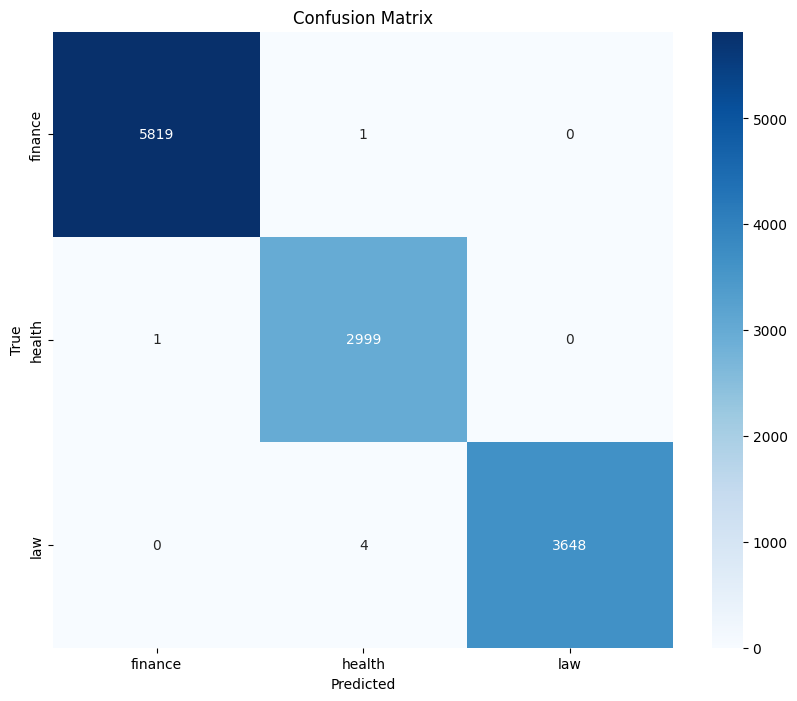

In [27]:
plot_confusion_matrix()

In [28]:
save_model(head, "head.pt")

Model head saved to head.pt


In [29]:
save_model(model, "model.pt")

Model head saved to model.pt


In [ ]:
model = (
    AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2").train().cuda(0)
)
head = Head(384, 3).train().to(model.device)
model.load_state_dict(torch.load("model.pt"))
head.load_state_dict(torch.load("head.pt"))

C:\Users\ixenr\AppData\Local\Temp\ipykernel_54092\3457885924.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))
C:\Users\ixenr

<All keys matched successfully>

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model, head):
        super().__init__()
        self.model = model
        self.head = head

    def forward(self, input):
        out = self.model.forward(**input)
        out = mean_pooling(out, input["attention_mask"])
        out = F.normalize(out, p=2, dim=1)
        return self.head(out)


custom_model = CustomModel(model, head)
custom_model.eval()

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_

In [22]:
import torch.onnx

In [ ]:
def export_model_to_onnx(model, save_path, input_shape=(1, 512), device="cuda"):
    model.eval()  # Set model to evaluation mode

    # Create dummy input for tracing
    input_ids = torch.ones(input_shape, dtype=torch.long).to(device)
    attention_mask = torch.ones(input_shape, dtype=torch.long).to(device)

    sample_input = {"input_ids": input_ids, "attention_mask": attention_mask}

    # Package inputs into a dictionary like the model expects
    dummy_input = {"input": sample_input}

    # Export the model with optimization options
    torch.onnx.export(
        model,  # model being run
        dummy_input,  # model input (or a tuple for multiple inputs)
        save_path,  # where to save the model
        export_params=True,  # store the trained parameter weights inside the model file
        opset_version=16,  # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=["input_ids", "attention_mask"],  # the model's input names
        output_names=["output"],  # the model's output names
        dynamic_axes={
            "input_ids": {
                0: "batch_size",
                1: "sequence_length",
            },  # variable length axes
            "attention_mask": {0: "batch_size", 1: "sequence_length"},
            "output": {0: "batch_size"},
        },
        keep_initializers_as_inputs=False,  # optimization for model size
        verbose=False,
    )
    print(f"Model exported to ONNX format at {save_path}")


def optimize_onnx_model(
    onnx_model_path, optimized_model_path=None, quantize=True, quantization_type="int8"
):
    import onnx
    from onnxruntime.transformers import optimizer
    from onnxruntime.transformers.fusion_options import FusionOptions
    from onnxruntime.quantization import quantize_dynamic, QuantType
    import onnx

    if optimized_model_path is None:
        optimized_model_path = onnx_model_path

    # Load the model
    model = onnx.load(onnx_model_path)

    # Skip BERT optimizer if the model was already optimized
    if "onnxruntime.transformers" not in model.producer_name:
        # Set up optimization options
        opt_options = FusionOptions("bert")
        opt_options.enable_embed_layer_norm = True
        opt_options.enable_attention = True
        opt_options.enable_skip_layer_norm = True
        opt_options.enable_gelu = True

        # Create the optimizer
        model_optimizer = optimizer.optimize_model(
            onnx_model_path,
            "bert",
            num_heads=12,  # Use detected value for MiniLM
            hidden_size=384,  # Adjust based on your model architecture
            optimization_options=opt_options,
        )

        # Save optimized model
        optimized_path = optimized_model_path.replace(".onnx", "_optimized.onnx")
        model_optimizer.save_model_to_file(optimized_path)
        print(f"Optimized model saved to {optimized_path}")
    else:
        # If already optimized, just use the original path
        optimized_path = onnx_model_path
        print(f"Model already optimized, skipping optimization")

    # Quantize if requested
    if quantize:
        try:
            if quantization_type == "int8":
                quant_type = QuantType.QInt8
            else:
                quant_type = QuantType.QFloat16

            quantized_path = optimized_path.replace(
                ".onnx", f"_{quantization_type}.onnx"
            )

            # Add DefaultTensorType to address the error
            extra_options = {"DefaultTensorType": onnx.TensorProto.FLOAT}

            quantize_dynamic(
                optimized_path,
                quantized_path,
                weight_type=quant_type,
                extra_options=extra_options,
            )
            print(f"Quantized model ({quantization_type}) saved to {quantized_path}")
            return quantized_path
        except Exception as e:
            print(f"Quantization failed with error: {e}")
            print("Returning optimized but non-quantized model")
            return optimized_path

    return optimized_path


def test_onnx_inference_performance(onnx_model_path, test_batch, num_runs=100):
    import onnxruntime as ort
    import time
    import numpy as np

    # Configure session options for best performance
    sess_options = ort.SessionOptions()
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    sess_options.intra_op_num_threads = 0  # 0 means use all available threads
    sess_options.execution_mode = ort.ExecutionMode.ORT_SEQUENTIAL

    # Provide all providers in priority order - let ONNXRuntime decide
    providers = [
        "CUDAExecutionProvider",
        "TensorrtExecutionProvider",
        "DmlExecutionProvider",
        "OpenVINOExecutionProvider",
        "ROCMExecutionProvider",
        "CoreMLExecutionProvider",
        "CPUExecutionProvider",
    ]

    try:
        session = ort.InferenceSession(
            onnx_model_path,
            sess_options=sess_options,
            providers=providers,  # Let ONNX runtime choose available providers
        )
        print(f"Using providers: {session.get_providers()}")
    except Exception as e:
        print(f"Failed to use custom providers. Error: {e}")
        print("Falling back to default providers")
        session = ort.InferenceSession(onnx_model_path)
        print(f"Using providers: {session.get_providers()}")

    # Prepare input
    input_msg = test_batch["messages"][:1]  # Just use first item for speed test
    inputs = tokenizer_func(input_msg)

    # Convert to numpy arrays for ONNX Runtime
    ort_inputs = {
        "input_ids": inputs["input_ids"].cpu().numpy(),
        "attention_mask": inputs["attention_mask"].cpu().numpy(),
    }

    # Warm-up runs
    for _ in range(10):
        session.run(["output"], ort_inputs)

    # Benchmark runs
    start_time = time.time()
    for _ in range(num_runs):
        output = session.run(["output"], ort_inputs)
    end_time = time.time()

    avg_time = (end_time - start_time) / num_runs * 1000  # ms

    print(f"Average inference time: {avg_time:.2f} ms per sample")
    print(f"Throughput: {1000/avg_time:.2f} samples/second")

    return avg_time


def create_optimized_model_pipeline(
    model, base_filename="text_classifier", quantize=True
):
    model_paths = {}

    # Step 1: Export original model
    orig_path = f"{base_filename}.onnx"
    export_model_to_onnx(model, orig_path)
    model_paths["original"] = orig_path

    # Step 2: Optimize model
    optimized_path = optimize_onnx_model(
        orig_path, optimized_model_path=None, quantize=False
    )
    model_paths["optimized"] = optimized_path

    # Step 3: Create quantized versions
    if quantize:
        # INT8 quantization
        int8_path = optimize_onnx_model(
            optimized_path,
            optimized_model_path=None,
            quantize=True,
            quantization_type="int8",
        )
        model_paths["int8"] = int8_path

        # FP16 quantization
        fp16_path = optimize_onnx_model(
            optimized_path,
            optimized_model_path=None,
            quantize=True,
            quantization_type="fp16",
        )
        model_paths["fp16"] = fp16_path

    return model_paths


def benchmark_all_models(model_paths, test_data):
    results = {}

    for model_type, path in model_paths.items():
        print(f"\n===== Benchmarking {model_type} model =====")
        try:
            latency = test_onnx_inference_performance(path, test_data)
            results[model_type] = latency
        except Exception as e:
            print(f"Error benchmarking {model_type} model: {e}")
            results[model_type] = None

    # Print comparison
    print("\n===== Performance Comparison =====")
    for model_type, latency in results.items():
        if latency is not None:
            print(f"{model_type.capitalize()} model: {latency:.2f} ms per sample")

    return results

In [26]:
model_paths = create_optimized_model_pipeline(custom_model)

Model exported to ONNX format at text_classifier.onnx
Optimized model saved to text_classifier_optimized.onnx
Model already optimized, skipping optimization


Quantized model (int8) saved to text_classifier_optimized_int8.onnx
Model already optimized, skipping optimization
Quantization failed with error: QFloat16
Returning optimized but non-quantized model


In [36]:
export_model_to_onnx(custom_model, "text_classifier.onnx")

Model exported to ONNX format at text_classifier.onnx


In [19]:
test_sample = next(iter(test_dataloader))

In [ ]:
import onnxruntime as ort


def test_onnx_model(onnx_path, test_data):
    """Test an exported ONNX model with sample data."""
    # Create an ONNX Runtime session
    session = ort.InferenceSession(onnx_path)

    # Prepare input data (assuming test_data is a batch from your test_dataloader)
    input_msg = test_data["messages"]
    inputs = tokenizer_func(input_msg)

    # Run inference
    onnx_inputs = {
        "input_ids": inputs["input_ids"].numpy(),
        "attention_mask": inputs["attention_mask"].numpy(),
    }

    onnx_outputs = session.run(None, onnx_inputs)

    # Process outputs
    predicted_labels = onnx_outputs[0].argmax(axis=1)

    print(f"ONNX model predictions: {predicted_labels}")
    return predicted_labels

In [21]:
test_onnx_model("text_classifier_optimized_int8.onnx", test_sample)

ONNX model predictions: [1 2 0 0 0 2 0 2 2 2 2 0 1 0 0 1 1 0 2 0 1 0 2 0 1 1 2 0 0 2 1 2 0 0 2 1 2
 0 1 2 1 1 1 1 2 1 0 0 2 0 0 2 0 2 0 0 0 2 0 1 0 0 0 2]


array([1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0,
       2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 0, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1,
       2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2])

In [ ]:
test_onnx_inference_performance("text_classifier_optimized_int8.onnx", test_sample)